In [3]:
import psutil, os, time, threading
def memwatch():
    while True:
        print(f"RAM {psutil.virtual_memory().percent:5.1f}% ", end="\r")
        time.sleep(5)
threading.Thread(target=memwatch, daemon=True).start()


In [4]:
# Install necessary packages
!pip install rasterio joblib cupy-cuda11x

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 63.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 MB 14.7 MB/s eta 0:00:00:00:010:01


In [4]:
import numpy as np
import rasterio
import os
from concurrent.futures import ThreadPoolExecutor

In [5]:
def load_bands(scene):
    suf = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
    stacks = []
    for s in suf:
        f = next(f for f in os.listdir(scene) if s in f)
        with rasterio.open(os.path.join(scene,f)) as src:
            b = src.read(1).astype(np.float32)
            b[b == src.nodata] = np.nan   # just drop nodata / border
            b /= 10000.0
            stacks.append(b)
    return np.stack(stacks, -1)


In [6]:
def flatten_scene(scene_path):
    # reads the six SR bands, converts nodata (‑9999) → NaN, scales to [0‑1]
    img = load_bands(scene_path)            # shape: (rows, cols, 6)

    # reshape to (n_pixels, 6) and keep rows that have *no* NaNs
    flat   = img.reshape(-1, 6)
    valid  = ~np.isnan(flat).any(axis=1)
    return flat[valid]                      # array of good spectra


In [7]:


pip install numpy tqdm


Note: you may need to restart the kernel to use updated packages.


In [8]:
from pathlib import Path

dataset_dir = Path("/kaggle/input/dataset/dataset")

scene_paths = sorted(p for p in dataset_dir.iterdir() if p.is_dir())

flat_scenes = [flatten_scene(p) for p in scene_paths]   # ← now works
print([f.shape for f in flat_scenes])                   # sanity‑check


[(40652607, 6), (40576321, 6), (40686725, 6), (40646486, 6), (40635746, 6)]


In [9]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm, trange

import numpy as np
import time

def downsample_scenes(scenes, sample_frac=0.2, random_seed=42):
    rng = np.random.RandomState(random_seed)
    out_data = []
    out_masks = []

    for s in scenes:
        mask = rng.rand(s.shape[0]) < sample_frac
        if not mask.any():
            mask[rng.randint(s.shape[0])] = True
        out_data.append(s[mask])
        out_masks.append(mask)
    
    return out_data, out_masks

def iikmc_cpu(scenes, k=8, max_iter=100, tol=0.01, n_workers=None, *, verbose=True):
    """
    Inter‑Image k‑Means Clustering (CPU version) with live progress output.

    Parameters
    ----------
    scenes   : list(ndarray)   Each scene shaped (n_pixels_i, n_bands)
    k        : int             Number of clusters
    max_iter : int             Safeguard upper limit on iterations
    tol      : float           Stop when (pixels‑changed / total_pixels) < tol
    n_workers: int | None      ThreadPoolExecutor size (defaults to os.cpu_count)
    verbose  : bool            Print per‑iteration stats if True

    Returns
    -------
    centers  : ndarray (k, n_bands)
    labels   : list(ndarray)   One label array per input scene
    """
    # ---------- class‑centre initialisation (Alg. 1 + 4) ----------
    stacked     = np.vstack(scenes)
    mins        = stacked.min(axis=0)
    maxs        = stacked.max(axis=0)
    interval    = (maxs - mins) / k
    centers     = np.array([mins + interval/2 + i*interval for i in range(k)],
                           dtype=np.float32)                # shape (k, n_bands)

    labels      = [np.full(s.shape[0], -1, dtype=np.int32) for s in scenes]
    total_px    = sum(s.shape[0] for s in scenes)
    n_bands     = centers.shape[1]

    global_start = time.perf_counter()

    for it in trange(max_iter, desc="IIkMC", unit="iter"):
        iter_start     = time.perf_counter()
        changed        = 0
        sums_global    = np.zeros_like(centers, dtype=np.float64)
        counts_global  = np.zeros(k, dtype=np.int64)

        # ---- classify one scene (runs in a worker) ----
        def classify(idx):
            X   = scenes[idx]                                # (n_i, n_bands)
            d   = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
            new = np.argmin(d, axis=1).astype(np.int32)      # (n_i,)
            # per‑scene accumulators
            s_local  = np.zeros_like(centers, dtype=np.float64)
            for c in range(k):
                mask = (new == c)
                if mask.any():
                    s_local[c] = X[mask].sum(axis=0)
            return idx, new, (labels[idx] != new).sum(), s_local, np.bincount(new, minlength=k)

        with ThreadPoolExecutor(max_workers=n_workers) as pool:
            futures = [pool.submit(classify, i) for i in range(len(scenes))]
            for fut in as_completed(futures):
                idx, new_lbl, chg, s_local, cnt_local = fut.result()
                labels[idx]     = new_lbl
                changed        += chg
                sums_global    += s_local
                counts_global  += cnt_local

        # ---- update centres (Alg. 6 line 8) ----
        mask = counts_global > 0
        centers[mask] = sums_global[mask] / counts_global[mask, None]

        # ---- progress print ----
        iter_time = time.perf_counter() - iter_start
        if verbose:
            pct = changed / total_px
            tqdm.write(f"[Iter {it+1:3d}]  "
                       f"changed: {changed:,} px  ({pct:.4%})  "
                       f"elapsed: {iter_time:6.2f} s")

        # ---- convergence test ----
        if changed / total_px < tol:
            total_time = time.perf_counter() - global_start
            if verbose:
                tqdm.write(f"\n✔ Converged after {it+1} iterations "
                           f"({total_time:.2f} s total, "
                           f"final change {changed/total_px:.4%})\n")
            break
    else:   # only runs if loop *didn’t* break
        total_time = time.perf_counter() - global_start
        if verbose:
            tqdm.write(f"\n⚠️  Reached max_iter={max_iter} "
                       f"without convergence ({total_time:.2f} s total)\n")

    return centers.astype(np.float32), labels


In [10]:
flat_scenes_ds, downsample_masks = downsample_scenes(flat_scenes, sample_frac=0.2,random_seed=123)
print("Original total pixels:", sum(s.shape[0] for s in flat_scenes))
print("Down-sampled total pixels:", sum(s.shape[0] for s in flat_scenes_ds))

Original total pixels: 203197885
Down-sampled total pixels: 40651997


In [14]:
centres, labels = iikmc_cpu(flat_scenes_ds, k=8)


IIkMC:   0%|          | 0/100 [00:00<?, ?iter/s]

IIkMC:   1%|          | 1/100 [00:10<17:26, 10.57s/iter]

[Iter   1]  changed: 40,651,997 px  (100.0000%)  elapsed:  10.57 s


IIkMC:   2%|▏         | 2/100 [00:21<17:33, 10.75s/iter]

[Iter   2]  changed: 3,842,431 px  (9.4520%)  elapsed:  10.87 s


IIkMC:   3%|▎         | 3/100 [00:31<17:00, 10.52s/iter]

[Iter   3]  changed: 2,977,021 px  (7.3232%)  elapsed:  10.25 s


IIkMC:   4%|▍         | 4/100 [00:41<16:40, 10.42s/iter]

[Iter   4]  changed: 2,194,913 px  (5.3993%)  elapsed:  10.26 s


IIkMC:   5%|▌         | 5/100 [00:53<16:52, 10.65s/iter]

[Iter   5]  changed: 2,016,381 px  (4.9601%)  elapsed:  11.06 s


IIkMC:   6%|▌         | 6/100 [01:03<16:29, 10.53s/iter]

[Iter   6]  changed: 1,972,029 px  (4.8510%)  elapsed:  10.29 s


IIkMC:   7%|▋         | 7/100 [01:13<16:16, 10.50s/iter]

[Iter   7]  changed: 1,754,273 px  (4.3153%)  elapsed:  10.43 s


IIkMC:   8%|▊         | 8/100 [01:24<16:18, 10.63s/iter]

[Iter   8]  changed: 1,600,731 px  (3.9376%)  elapsed:  10.91 s


IIkMC:   9%|▉         | 9/100 [01:34<15:53, 10.48s/iter]

[Iter   9]  changed: 1,203,451 px  (2.9604%)  elapsed:  10.14 s


IIkMC:  10%|█         | 10/100 [01:45<15:36, 10.41s/iter]

[Iter  10]  changed: 1,245,345 px  (3.0634%)  elapsed:  10.26 s


IIkMC:  11%|█         | 11/100 [01:55<15:36, 10.52s/iter]

[Iter  11]  changed: 1,464,921 px  (3.6036%)  elapsed:  10.76 s


IIkMC:  12%|█▏        | 12/100 [02:05<15:15, 10.40s/iter]

[Iter  12]  changed: 1,556,589 px  (3.8291%)  elapsed:  10.13 s


IIkMC:  13%|█▎        | 13/100 [02:16<15:01, 10.36s/iter]

[Iter  13]  changed: 1,539,003 px  (3.7858%)  elapsed:  10.25 s


IIkMC:  14%|█▍        | 14/100 [02:26<14:52, 10.38s/iter]

[Iter  14]  changed: 1,453,844 px  (3.5763%)  elapsed:  10.43 s


IIkMC:  15%|█▌        | 15/100 [02:37<14:45, 10.42s/iter]

[Iter  15]  changed: 1,340,768 px  (3.2982%)  elapsed:  10.51 s


IIkMC:  16%|█▌        | 16/100 [02:47<14:30, 10.36s/iter]

[Iter  16]  changed: 1,204,093 px  (2.9620%)  elapsed:  10.23 s


IIkMC:  17%|█▋        | 17/100 [02:57<14:14, 10.29s/iter]

[Iter  17]  changed: 1,064,458 px  (2.6185%)  elapsed:  10.12 s


IIkMC:  18%|█▊        | 18/100 [03:08<14:11, 10.39s/iter]

[Iter  18]  changed: 913,449 px  (2.2470%)  elapsed:  10.62 s


IIkMC:  19%|█▉        | 19/100 [03:18<13:58, 10.35s/iter]

[Iter  19]  changed: 772,341 px  (1.8999%)  elapsed:  10.24 s


IIkMC:  20%|██        | 20/100 [03:28<13:42, 10.28s/iter]

[Iter  20]  changed: 645,987 px  (1.5891%)  elapsed:  10.13 s


IIkMC:  21%|██        | 21/100 [03:42<15:11, 11.54s/iter]

[Iter  21]  changed: 531,413 px  (1.3072%)  elapsed:  14.46 s


IIkMC:  22%|██▏       | 22/100 [03:53<14:46, 11.36s/iter]

[Iter  22]  changed: 437,032 px  (1.0751%)  elapsed:  10.95 s


IIkMC:  22%|██▏       | 22/100 [04:04<14:25, 11.09s/iter]

[Iter  23]  changed: 360,523 px  (0.8869%)  elapsed:  10.12 s

✔ Converged after 23 iterations (244.06 s total, final change 0.8869%)



In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def map_labels_back_downsampled(scene_path, downsample_mask, labels_1d):
    img = load_bands(scene_path)  # (rows, cols, 6)
    rows, cols = img.shape[:2]
    flat = img.reshape(-1, 6)
    valid = ~np.isnan(flat).any(axis=1)

    if downsample_mask.sum() != len(labels_1d):
        raise ValueError(f"label mismatch: {downsample_mask.sum()} vs {len(labels_1d)}")

    out = np.full(rows * cols, np.nan, np.float32)
    valid_idx = np.where(valid)[0]
    downsampled_idx = valid_idx[downsample_mask]
    out[downsampled_idx] = labels_1d.astype(np.float32)
    return out.reshape(rows, cols)

for sc_path, mask, scene_labels in zip(scene_paths, downsample_masks_Ds, labels):
    try:
        lbl2d = map_labels_back_downsampled(sc_path, mask, scene_labels)
        visualize_cluster_map(lbl2d, title=f"IIkMC clusters – {sc_path.name}", k=centres.shape[0])
    except Exception as e:
        print(f"Skipping {sc_path.name}: {e}")


In [15]:
# Step 1: Downsample scenes
small_scenes = downsample_scenes(flat_scenes, sample_frac=0.2)

# Step 2: Run clustering
centers, labels = iikmc_cpu(small_scenes, k=8, n_workers=None)

# Step 3: Visualize
for sc_path, lbl in zip(scene_paths, labels):      # pair each path with its label
    try:
        lbl2d = map_labels_back(sc_path, lbl)
        visualize_cluster_map(lbl2d, title=f"IIkMC clusters – {sc_path.name}", k=centers.shape[0])
    except Exception as e:
        print(f"⚠️ Error mapping scene {sc_path.name}: {e}")


IIkMC:   0%|          | 0/100 [00:00<?, ?iter/s]

IIkMC:   1%|          | 1/100 [00:11<19:02, 11.54s/iter]

[Iter   1]  changed: 40,637,586 px  (100.0000%)  elapsed:  11.53 s


IIkMC:   2%|▏         | 2/100 [00:22<18:20, 11.23s/iter]

[Iter   2]  changed: 3,813,513 px  (9.3842%)  elapsed:  11.01 s


IIkMC:   3%|▎         | 3/100 [00:33<17:37, 10.90s/iter]

[Iter   3]  changed: 2,981,239 px  (7.3362%)  elapsed:  10.49 s


IIkMC:   4%|▍         | 4/100 [00:43<17:09, 10.72s/iter]

[Iter   4]  changed: 2,200,856 px  (5.4158%)  elapsed:  10.45 s


IIkMC:   5%|▌         | 5/100 [00:54<16:52, 10.66s/iter]

[Iter   5]  changed: 2,027,003 px  (4.9880%)  elapsed:  10.55 s


IIkMC:   6%|▌         | 6/100 [01:04<16:37, 10.61s/iter]

[Iter   6]  changed: 1,986,076 px  (4.8873%)  elapsed:  10.50 s


IIkMC:   7%|▋         | 7/100 [01:14<16:20, 10.54s/iter]

[Iter   7]  changed: 1,763,586 px  (4.3398%)  elapsed:  10.39 s


IIkMC:   8%|▊         | 8/100 [01:25<16:02, 10.46s/iter]

[Iter   8]  changed: 1,609,082 px  (3.9596%)  elapsed:  10.29 s


IIkMC:   9%|▉         | 9/100 [01:36<16:09, 10.66s/iter]

[Iter   9]  changed: 1,210,881 px  (2.9797%)  elapsed:  11.08 s


IIkMC:  10%|█         | 10/100 [01:46<15:51, 10.57s/iter]

[Iter  10]  changed: 1,238,865 px  (3.0486%)  elapsed:  10.39 s


IIkMC:  11%|█         | 11/100 [01:57<15:34, 10.50s/iter]

[Iter  11]  changed: 1,456,774 px  (3.5848%)  elapsed:  10.32 s


IIkMC:  12%|█▏        | 12/100 [02:07<15:31, 10.59s/iter]

[Iter  12]  changed: 1,550,865 px  (3.8163%)  elapsed:  10.79 s


IIkMC:  13%|█▎        | 13/100 [02:18<15:15, 10.52s/iter]

[Iter  13]  changed: 1,531,515 px  (3.7687%)  elapsed:  10.37 s


IIkMC:  14%|█▍        | 14/100 [02:28<14:59, 10.46s/iter]

[Iter  14]  changed: 1,446,809 px  (3.5603%)  elapsed:  10.31 s


IIkMC:  15%|█▌        | 15/100 [02:39<15:01, 10.60s/iter]

[Iter  15]  changed: 1,334,862 px  (3.2848%)  elapsed:  10.93 s


IIkMC:  16%|█▌        | 16/100 [02:49<14:43, 10.51s/iter]

[Iter  16]  changed: 1,198,049 px  (2.9481%)  elapsed:  10.29 s


IIkMC:  17%|█▋        | 17/100 [03:00<14:25, 10.43s/iter]

[Iter  17]  changed: 1,059,555 px  (2.6073%)  elapsed:  10.24 s


IIkMC:  18%|█▊        | 18/100 [03:11<14:29, 10.60s/iter]

[Iter  18]  changed: 908,741 px  (2.2362%)  elapsed:  11.00 s


IIkMC:  19%|█▉        | 19/100 [03:21<14:10, 10.50s/iter]

[Iter  19]  changed: 768,811 px  (1.8919%)  elapsed:  10.26 s


IIkMC:  20%|██        | 20/100 [03:31<14:01, 10.52s/iter]

[Iter  20]  changed: 643,939 px  (1.5846%)  elapsed:  10.56 s


IIkMC:  21%|██        | 21/100 [03:42<14:01, 10.65s/iter]

[Iter  21]  changed: 529,079 px  (1.3019%)  elapsed:  10.94 s


IIkMC:  22%|██▏       | 22/100 [03:53<13:46, 10.60s/iter]

[Iter  22]  changed: 435,185 px  (1.0709%)  elapsed:  10.49 s


IIkMC:  22%|██▏       | 22/100 [04:03<14:24, 11.08s/iter]


[Iter  23]  changed: 360,037 px  (0.8860%)  elapsed:  10.43 s

✔ Converged after 23 iterations (243.74 s total, final change 0.8860%)

⚠️ Error mapping scene scene1: label mismatch: 40652607 vs 8128170
⚠️ Error mapping scene scene2: label mismatch: 40576321 vs 8118458
⚠️ Error mapping scene scene3: label mismatch: 40686725 vs 8133285
⚠️ Error mapping scene scene4: label mismatch: 40646486 vs 8130886
⚠️ Error mapping scene scene5: label mismatch: 40635746 vs 8126787


In [23]:
for sc_path, mask, scene_labels in zip(scene_paths, downsample_masks, labels):
    try:
        lbl2d = map_labels_back_downsampled(sc_path, mask, scene_labels)
        visualize_cluster_map(lbl2d, title=f"IIkMC clusters – {sc_path.name}", k=centres.shape[0])
    except Exception as e:
        print(f"Skipping {sc_path.name}: {e}")


In [16]:
# STEP 1: Downsample the flat scenes along with their paths
downsampled_pairs = []  # list of (scene_path, small_scene)
for path, full in zip(scene_paths, flat_scenes):
    small = downsample_scenes([full], sample_frac=0.2)[0]
    downsampled_pairs.append((path, small))

# STEP 2: Extract just the scenes for clustering
small_scenes = [s for _, s in downsampled_pairs]

# STEP 3: Run clustering
centers, labels = iikmc_cpu(small_scenes, k=8, n_workers=None)

# STEP 4: Visualize — now path matches the downsampled label!
for sc_path, mask, scene_labels in zip(scene_paths, downsample_masks, labels):
    try:
        lbl2d = map_labels_back_downsampled(sc_path, mask, scene_labels)
        visualize_cluster_map(lbl2d, title=f"IIkMC clusters – {sc_path.name}", k=centres.shape[0])
    except Exception as e:
        print(f"Skipping {sc_path.name}: {e}")


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 8128170 and the array at index 1 has size 8112769

IIkMC:   0%|          | 0/100 [00:00<?, ?iter/s]

IIkMC:   1%|          | 1/100 [00:10<17:45, 10.76s/iter]

[Iter   1]  changed: 40,643,681 px  (100.0000%)  elapsed:  10.76 s


IIkMC:   2%|▏         | 2/100 [00:21<17:33, 10.75s/iter]

[Iter   2]  changed: 3,842,234 px  (9.4535%)  elapsed:  10.74 s


IIkMC:   3%|▎         | 3/100 [00:31<16:53, 10.45s/iter]

[Iter   3]  changed: 2,970,158 px  (7.3078%)  elapsed:  10.09 s


IIkMC:   4%|▍         | 4/100 [00:41<16:31, 10.33s/iter]

[Iter   4]  changed: 2,196,297 px  (5.4038%)  elapsed:  10.14 s


IIkMC:   5%|▌         | 5/100 [00:52<16:38, 10.51s/iter]

[Iter   5]  changed: 2,031,586 px  (4.9985%)  elapsed:  10.83 s


IIkMC:   6%|▌         | 6/100 [01:02<16:14, 10.36s/iter]

[Iter   6]  changed: 1,992,101 px  (4.9014%)  elapsed:  10.07 s


IIkMC:   7%|▋         | 7/100 [01:12<15:56, 10.29s/iter]

[Iter   7]  changed: 1,778,179 px  (4.3750%)  elapsed:  10.13 s


IIkMC:   8%|▊         | 8/100 [01:24<16:17, 10.63s/iter]

[Iter   8]  changed: 1,609,268 px  (3.9595%)  elapsed:  11.35 s


IIkMC:   9%|▉         | 9/100 [01:34<15:55, 10.50s/iter]

[Iter   9]  changed: 1,200,726 px  (2.9543%)  elapsed:  10.23 s


IIkMC:  10%|█         | 10/100 [01:44<15:36, 10.41s/iter]

[Iter  10]  changed: 1,250,361 px  (3.0764%)  elapsed:  10.18 s


IIkMC:  11%|█         | 11/100 [01:55<15:31, 10.47s/iter]

[Iter  11]  changed: 1,456,123 px  (3.5827%)  elapsed:  10.61 s


IIkMC:  12%|█▏        | 12/100 [02:05<15:16, 10.41s/iter]

[Iter  12]  changed: 1,550,817 px  (3.8156%)  elapsed:  10.27 s


IIkMC:  13%|█▎        | 13/100 [02:15<14:59, 10.34s/iter]

[Iter  13]  changed: 1,518,591 px  (3.7364%)  elapsed:  10.16 s


IIkMC:  14%|█▍        | 14/100 [02:25<14:43, 10.27s/iter]

[Iter  14]  changed: 1,434,811 px  (3.5302%)  elapsed:  10.12 s


IIkMC:  15%|█▌        | 15/100 [02:36<14:43, 10.40s/iter]

[Iter  15]  changed: 1,319,622 px  (3.2468%)  elapsed:  10.68 s


IIkMC:  16%|█▌        | 16/100 [02:46<14:24, 10.30s/iter]

[Iter  16]  changed: 1,181,701 px  (2.9075%)  elapsed:  10.06 s


IIkMC:  17%|█▋        | 17/100 [02:56<14:09, 10.24s/iter]

[Iter  17]  changed: 1,042,407 px  (2.5647%)  elapsed:  10.11 s


IIkMC:  18%|█▊        | 18/100 [03:07<14:08, 10.35s/iter]

[Iter  18]  changed: 890,969 px  (2.1921%)  elapsed:  10.59 s


IIkMC:  19%|█▉        | 19/100 [03:17<13:56, 10.32s/iter]

[Iter  19]  changed: 754,564 px  (1.8565%)  elapsed:  10.27 s


IIkMC:  20%|██        | 20/100 [03:27<13:43, 10.30s/iter]

[Iter  20]  changed: 627,890 px  (1.5449%)  elapsed:  10.23 s


IIkMC:  21%|██        | 21/100 [03:38<13:47, 10.47s/iter]

[Iter  21]  changed: 514,910 px  (1.2669%)  elapsed:  10.88 s


IIkMC:  22%|██▏       | 22/100 [03:48<13:31, 10.40s/iter]

[Iter  22]  changed: 424,210 px  (1.0437%)  elapsed:  10.22 s


IIkMC:  22%|██▏       | 22/100 [03:58<14:07, 10.86s/iter]


[Iter  23]  changed: 351,164 px  (0.8640%)  elapsed:  10.14 s

✔ Converged after 23 iterations (238.96 s total, final change 0.8640%)



/tmp/ipykernel_35/4148401558.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = ListedColormap(plt.cm.get_cmap('tab10', k).colors[:k])


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


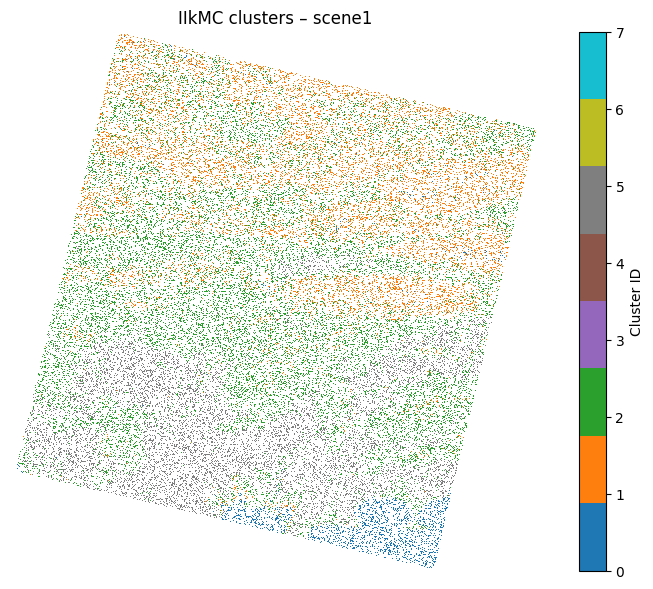

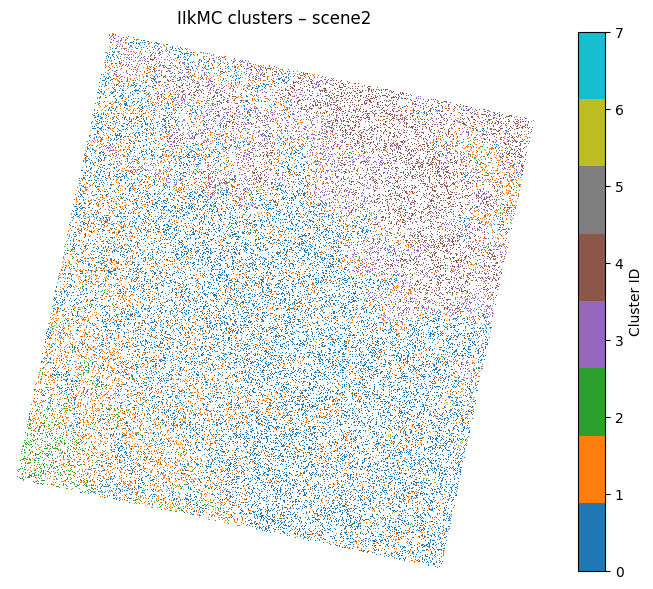

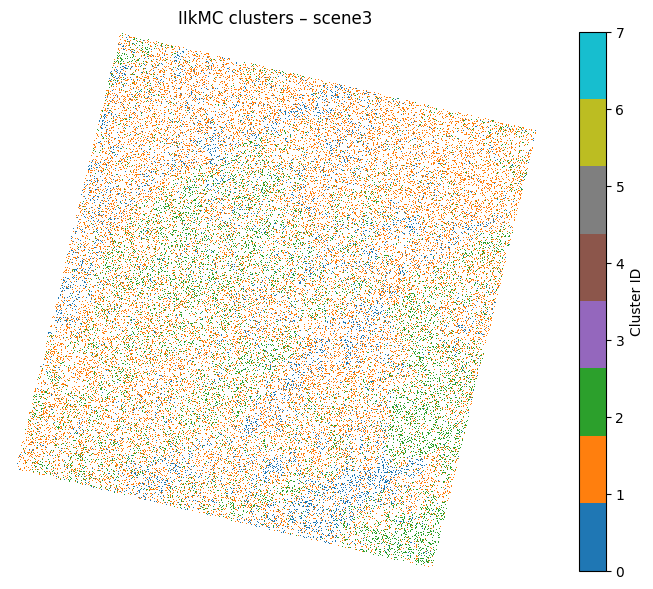

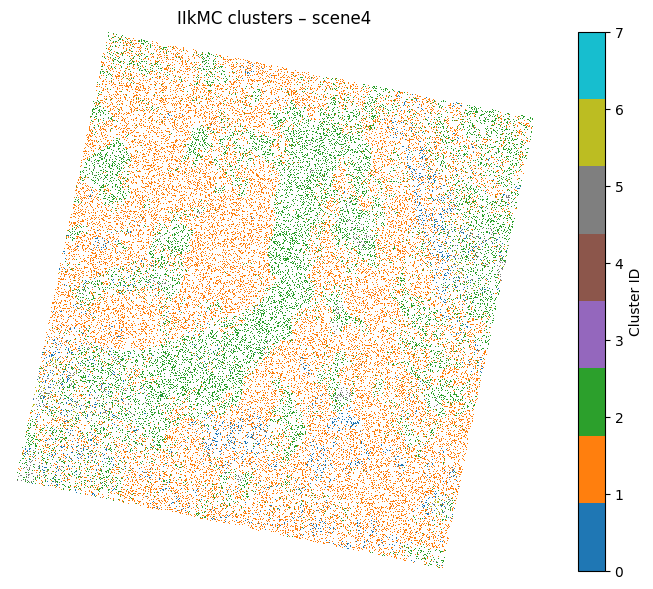

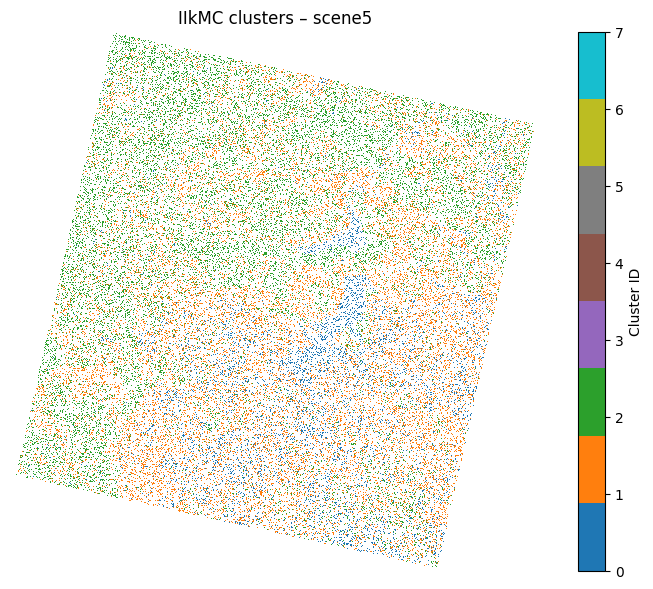

In [17]:
# STEP 1 — Pair scene path with flat scene
scene_pairs = list(zip(scene_paths, flat_scenes))  # full-resolution

# STEP 2 — Downsample scene PATHS together
from numpy.random import default_rng
rng = default_rng(42)

sample_frac = 0.2
sampled_pairs = []
for path, scene in scene_pairs:
    n = len(scene)
    mask = rng.random(n) < sample_frac
    if not mask.any():
        mask[rng.integers(0, n)] = True
    sampled_scene = scene[mask]
    sampled_pairs.append((path, sampled_scene, mask))  # save mask too!

# STEP 3 — Extract scenes and cluster
small_scenes = [s for _, s, _ in sampled_pairs]
centers, labels = iikmc_cpu(small_scenes, k=8)

# STEP 4 — Map results using mask (← key fix!)
for (sc_path, _, mask), lbl in zip(sampled_pairs, labels):
    try:
        img = load_bands(sc_path)                        # shape: (H, W, B)
        valid = ~np.isnan(img).any(-1)                   # valid pixels in full scene
        rows, cols = img.shape[:2]

        # check that mask maps to valid
        if mask.sum() != len(lbl):
            raise ValueError(f"label mismatch: {mask.sum()} vs {len(lbl)}")

        # create empty flat array
        flat = np.full(rows * cols, np.nan, dtype=np.float32)
        valid_flat = valid.ravel()
        submask = np.zeros_like(valid_flat)
        submask[valid_flat] = mask                      # mask inside valid only
        flat[submask] = lbl.astype(np.float32)

        # reshape to 2D image
        label_map = flat.reshape(rows, cols)

        # visualize
        visualize_cluster_map(label_map, title=f"IIkMC clusters – {sc_path.name}", k=centers.shape[0])

    except Exception as e:
        print(f"⚠️ Error in {sc_path.name}: {e}")


In [26]:
import numpy as np

def assign_full_labels(scene_path, centres, block=1_000_000):
    """
    Flatten the scene, then assign every pixel to the nearest centre
    in blocks of up to `block` rows to avoid OOM.
    """
    X = flatten_scene(scene_path)          # (n_pixels, 6)
    n = X.shape[0]
    labels = np.empty(n, dtype=np.int32)
    for start in range(0, n, block):
        end = min(start+block, n)
        chunk = X[start:end]
        # squared distances to each centre
        d2 = ((chunk[:, None, :] - centres[None, :, :])**2).sum(axis=2)
        labels[start:end] = np.argmin(d2, axis=1)
    return labels

# now loop over your scenes:
for scene_path in scene_paths:
    full_lbls = assign_full_labels(scene_path, centers)
    lbl2d     = map_labels_back(scene_path, full_lbls)
    visualize_cluster_map(
        lbl2d,
        title=f"IIkMC clusters — {scene_path.name}",
        k=centers.shape[0]
    )


IIkMC:   0%|          | 0/100 [00:00<?, ?iter/s]

IIkMC:   1%|          | 1/100 [00:09<16:28,  9.99s/iter]

[Iter   1]  changed: 40,637,586 px  (100.0000%)  elapsed:   9.99 s


IIkMC:   2%|▏         | 2/100 [00:19<16:08,  9.89s/iter]

[Iter   2]  changed: 3,813,513 px  (9.3842%)  elapsed:   9.81 s


IIkMC:   3%|▎         | 3/100 [00:30<16:18, 10.09s/iter]

[Iter   3]  changed: 2,981,239 px  (7.3362%)  elapsed:  10.32 s


IIkMC:   4%|▍         | 4/100 [00:39<15:57,  9.97s/iter]

[Iter   4]  changed: 2,200,856 px  (5.4158%)  elapsed:   9.80 s


IIkMC:   5%|▌         | 5/100 [00:49<15:44,  9.94s/iter]

[Iter   5]  changed: 2,027,003 px  (4.9880%)  elapsed:   9.87 s


IIkMC:   6%|▌         | 6/100 [01:00<15:52, 10.13s/iter]

[Iter   6]  changed: 1,986,076 px  (4.8873%)  elapsed:  10.51 s


IIkMC:   7%|▋         | 7/100 [01:10<15:34, 10.05s/iter]

[Iter   7]  changed: 1,763,586 px  (4.3398%)  elapsed:   9.86 s


IIkMC:   8%|▊         | 8/100 [01:20<15:19, 10.00s/iter]

[Iter   8]  changed: 1,609,082 px  (3.9596%)  elapsed:   9.89 s


IIkMC:   9%|▉         | 9/100 [01:30<15:25, 10.17s/iter]

[Iter   9]  changed: 1,210,881 px  (2.9797%)  elapsed:  10.53 s


IIkMC:  10%|█         | 10/100 [01:40<15:05, 10.07s/iter]

[Iter  10]  changed: 1,238,865 px  (3.0486%)  elapsed:   9.84 s


IIkMC:  11%|█         | 11/100 [01:50<14:50, 10.00s/iter]

[Iter  11]  changed: 1,456,774 px  (3.5848%)  elapsed:   9.85 s


IIkMC:  12%|█▏        | 12/100 [02:00<14:38,  9.98s/iter]

[Iter  12]  changed: 1,550,865 px  (3.8163%)  elapsed:   9.92 s


IIkMC:  13%|█▎        | 13/100 [02:10<14:39, 10.11s/iter]

[Iter  13]  changed: 1,531,515 px  (3.7687%)  elapsed:  10.42 s


IIkMC:  14%|█▍        | 14/100 [02:20<14:25, 10.07s/iter]

[Iter  14]  changed: 1,446,809 px  (3.5603%)  elapsed:   9.96 s


IIkMC:  15%|█▌        | 15/100 [02:30<14:11, 10.02s/iter]

[Iter  15]  changed: 1,334,862 px  (3.2848%)  elapsed:   9.90 s


IIkMC:  16%|█▌        | 16/100 [02:40<14:11, 10.14s/iter]

[Iter  16]  changed: 1,198,049 px  (2.9481%)  elapsed:  10.42 s


IIkMC:  17%|█▋        | 17/100 [02:50<13:55, 10.06s/iter]

[Iter  17]  changed: 1,059,555 px  (2.6073%)  elapsed:   9.89 s


IIkMC:  18%|█▊        | 18/100 [03:00<13:40, 10.01s/iter]

[Iter  18]  changed: 908,741 px  (2.2362%)  elapsed:   9.87 s


IIkMC:  19%|█▉        | 19/100 [03:11<13:42, 10.16s/iter]

[Iter  19]  changed: 768,811 px  (1.8919%)  elapsed:  10.51 s


IIkMC:  20%|██        | 20/100 [03:21<13:29, 10.12s/iter]

[Iter  20]  changed: 643,939 px  (1.5846%)  elapsed:  10.04 s


IIkMC:  21%|██        | 21/100 [03:31<13:15, 10.07s/iter]

[Iter  21]  changed: 529,079 px  (1.3019%)  elapsed:   9.95 s


IIkMC:  22%|██▏       | 22/100 [03:41<13:09, 10.12s/iter]

[Iter  22]  changed: 435,185 px  (1.0709%)  elapsed:  10.22 s


IIkMC:  22%|██▏       | 22/100 [03:51<13:40, 10.52s/iter]

[Iter  23]  changed: 360,037 px  (0.8860%)  elapsed:  10.04 s

✔ Converged after 23 iterations (231.49 s total, final change 0.8860%)



In [ ]:

# ---- nice visual output for cluster maps ----
def visualize_cluster_map(label_map, title="", k=8, figsize=(10, 7)):
    cmap = ListedColormap(plt.cm.get_cmap('tab10', k).colors[:k])
    masked = np.ma.masked_where(np.isnan(label_map), label_map)
    plt.figure(figsize=figsize)
    plt.imshow(masked, cmap=cmap, interpolation='nearest')
    plt.title(title)
    plt.axis('off')
    plt.colorbar(ticks=range(k), label='Cluster ID')
    plt.show()

# ---- reconstruct cluster labels in full image layout ----
def reconstruct_label_map(scene_path, valid_mask, sampled_mask, labels_1d):
    img = load_bands(scene_path)
    rows, cols = img.shape[:2]
    flat = np.full(rows * cols, np.nan, dtype=np.float32)

    # Apply mask to valid pixel space
    valid_flat = valid_mask.ravel()
    target_mask = np.zeros_like(valid_flat, dtype=bool)
    target_mask[valid_flat] = sampled_mask

    if target_mask.sum() != len(labels_1d):
        raise ValueError(f"Label mismatch: {target_mask.sum()} vs {len(labels_1d)}")

    flat[target_mask] = labels_1d.astype(np.float32)
    return flat.reshape(rows, cols)

# ---- IIkMC pipeline ----
def downsample_scene(scene, frac=0.2, rng=None):
    if rng is None:
        rng = np.random.default_rng(42)
    mask = rng.random(len(scene)) < frac
    if not mask.any():
        mask[rng.integers(len(scene))] = True
    return mask

# ---------- MAIN WORKFLOW ----------
dataset_dir = Path("/kaggle/input/dataset/dataset")
scene_paths = sorted(p for p in dataset_dir.iterdir() if p.is_dir())

# STEP 1: Flatten full-resolution scenes
flat_scenes = [flatten_scene(p) for p in scene_paths]  # your own logic
scene_info = list(zip(scene_paths, flat_scenes))

# STEP 2: Downsample and collect masks
rng = np.random.default_rng(42)
sampled_data = []
for path, scene in scene_info:
    mask = downsample_scene(scene, frac=0.2, rng=rng)
    sampled = scene[mask]
    sampled_data.append((path, sampled, mask))

# STEP 3: Cluster downsampled scenes
sampled_scenes = [s for _, s, _ in sampled_data]
centers, labels = iikmc_cpu(sampled_scenes, k=8)

# STEP 4: Visualize
for (path, _, sampled_mask), label_1d in zip(sampled_data, labels):
    try:
        img = load_bands(path)
        valid = ~np.isnan(img).any(-1)
        label_map = reconstruct_label_map(path, valid, sampled_mask, label_1d)
        visualize_cluster_map(label_map, title=f"IIkMC clusters – {path.name}", k=centers.shape[0])
    except Exception as e:
        print(f"⚠️ Could not plot {path.name}: {e}")

IIkMC:   0%|          | 0/100 [00:00<?, ?iter/s]

Crashed as ram exceeded, will do a vanilla version processing one image at a time

In [ ]:
"""
Streaming CPU implementation of Inter‑Image k‑Means Clustering (IIkMC)
   • Processes one scene at a time  ➟ memory ~ size_of_largest_scene
   • Uses centre‑shift tolerance instead of 'nChanged / total' to avoid
     storing labels from previous iterations
   • Still pure NumPy ➟ portable, no external compile step
"""

import numpy as np, os, rasterio
from pathlib import Path
from tqdm import trange

# ---------- helpers you already have ----------

def load_bands(scene):
    suf = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
    stacks = []
    for s in suf:
        f = next(f for f in os.listdir(scene) if s in f)
        with rasterio.open(os.path.join(scene, f)) as src:
            b = src.read(1).astype(np.float32)
            b[b == src.nodata] = np.nan
            b /= 10000.0
            stacks.append(b)
    return np.stack(stacks, -1)          # (rows, cols, 6)

def flatten_scene(scene):
    img  = load_bands(scene)             # nodata → NaN
    flat = img.reshape(-1, 6)
    return flat[~np.isnan(flat).any(1)]  # (n_valid, 6)

# ---------- new: streaming IIkMC ----------

def iikmc_stream(scene_paths, k=8, max_iter=100, tol_shift=1e-4):
    """
    Memory‑light IIkMC: loads and processes one scene at a time.
    tol_shift  – stop when centre RMS shift < tol_shift
    returns    – (centres, {scene_path: final_labels})
    """
    # --- global min/max pass (Alg.4) ---
    mins = np.full(6, np.inf,  dtype=np.float64)
    maxs = np.full(6, -np.inf, dtype=np.float64)
    for p in scene_paths:
        X = flatten_scene(p)
        mins = np.minimum(mins, X.min(0))
        maxs = np.maximum(maxs, X.max(0))

    interval = (maxs - mins) / k
    centres  = np.array([mins + interval/2 + i*interval for i in range(k)],
                        dtype=np.float32)          # (k,6)

    # storage for final labels
    final_labels = {p: None for p in scene_paths}

    for it in trange(max_iter, desc="IIkMC‑stream", unit="iter"):
        old = centres.copy().astype(np.float64)
        sums   = np.zeros_like(old)
        counts = np.zeros(k, dtype=np.int64)

        # ---- single pass over all scenes ----
        for p in scene_paths:
            X = flatten_scene(p)
            # distance^2 without sqrt ➟ less RAM
            d2 = ((X[:, None, :] - centres[None, :, :]) ** 2).sum(2)
            lbl = np.argmin(d2, axis=1).astype(np.int32)

            # accumulate
            for c in range(k):
                mask = (lbl == c)
                if mask.any():
                    sums[c]   += X[mask].sum(0)
                    counts[c] += mask.sum()

            final_labels[p] = lbl  # keep only current iter's labels

        # ---- update centres (Alg.6) ----
        mask = counts > 0
        centres[mask] = (sums[mask] / counts[mask, None]).astype(np.float32)

        # ---- convergence: centre shift ---
        shift = np.linalg.norm(centres - old) / k
        if shift < tol_shift:
            print(f"\nConverged in {it+1} iterations  –  centre shift {shift:.2e}")
            break

    return centres, final_labels


In [ ]:
dataset_dir = Path("/content/drive/MyDrive/PDC/dataset")
scene_paths = sorted(p for p in dataset_dir.iterdir() if p.is_dir())

centres, labels_dict = iikmc_stream(
        scene_paths,
        k=8,
        max_iter=100,
        tol_shift=1e-4)     # tweak if it stops too soon / late


Ram still crashing, trying Block‑wise IIkMC (process 1 M pixels at a time)

In [ ]:
from tqdm import trange


In [ ]:
def iikmc_block(stream_paths, k=8, chunk=1_000_000, tol_shift=1e-4, max_iter=100):
    # init mins/maxs
    mins = np.full(6, np.inf)
    maxs = np.full(6, -np.inf)
    for p in stream_paths:
        X = flatten_scene(p)
        mins = np.minimum(mins, X.min(0))
        maxs = np.maximum(maxs, X.max(0))
    centres = np.stack([mins + (i+0.5)*(maxs-mins)/k for i in range(k)]).astype(np.float32)

    labels_dict = {}
    for it in trange(max_iter, desc="IIkMC‑block"):
        old = centres.copy()
        sums = np.zeros_like(centres, np.float64)
        cnts = np.zeros(k, np.int64)

        # ----- one pass through all scenes -----
        for p in stream_paths:
            X = flatten_scene(p)            # (n_i, 6)
            n  = X.shape[0]
            lbls = np.empty(n, np.int32)

            # process in blocks of ≤ chunk rows
            for start in range(0, n, chunk):
                end   = min(start+chunk, n)
                lbls[start:end] = classify_block(X[start:end], centres)

            # accumulate
            for c in range(k):
                mask = lbls == c
                if mask.any():
                    sums[c] += X[mask].sum(0)
                    cnts[c] += mask.sum()
            labels_dict[p] = lbls

        # update centres
        mask = cnts > 0
        centres[mask] = (sums[mask] / cnts[mask, None]).astype(np.float32)

        shift = np.linalg.norm(centres - old) / k
        if shift < tol_shift:
            print(f"\nconverged {it+1} its  shift {shift:.2e}")
            break
    return centres, labels_dict


In [ ]:
def classify_block(X_block, centres):
    # Euclidean distances, but we avoid allocating (n×k) full matrix
    # by expanding centres one at a time
    k, _ = centres.shape
    labels = np.empty(X_block.shape[0], np.int32)
    for c in range(k):
        d2 = np.sum((X_block - centres[c])**2, axis=1)
        if c == 0:
            best_d2   = d2
            best_lbl  = np.zeros_like(d2, np.int32)
        else:
            mask = d2 < best_d2
            best_d2[mask] = d2[mask]
            best_lbl[mask] = c
    labels[:] = best_lbl
    return labels


In [ ]:
dataset_dir = Path("/content/drive/MyDrive/PDC/dataset")
scene_paths = sorted(p for p in dataset_dir.iterdir() if p.is_dir())

centres, labels_dict = iikmc_block(
        scene_paths,
        k=8,
        max_iter=10,
        tol_shift=1e-4)     # tweak if it stops too soon / late


In [24]:
# ========== Downsampling ==========
def downsample_scenes(scenes, sample_frac=0.2, random_seed=42):
    rng = np.random.RandomState(random_seed)
    out_data, out_masks = [], []
    for s in scenes:
        mask = rng.rand(s.shape[0]) < sample_frac
        if not mask.any():
            mask[rng.randint(s.shape[0])] = True
        out_data.append(s[mask])
        out_masks.append(mask)
    return out_data, out_masks

In [25]:


# ========== Clustering ==========
def iikmc_cpu(scenes, k=8, max_iter=100, tol=0.01, n_workers=None, *, verbose=True):
    stacked = np.vstack(scenes)
    mins = stacked.min(axis=0)
    maxs = stacked.max(axis=0)
    interval = (maxs - mins) / k
    centers = np.array([mins + interval/2 + i*interval for i in range(k)], dtype=np.float32)

    labels = [np.full(s.shape[0], -1, dtype=np.int32) for s in scenes]
    total_px = sum(s.shape[0] for s in scenes)

    for it in trange(max_iter, desc="IIkMC", unit="iter"):
        changed = 0
        sums_global = np.zeros_like(centers, dtype=np.float64)
        counts_global = np.zeros(k, dtype=np.int64)

        def classify(idx):
            X = scenes[idx]
            d = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
            new = np.argmin(d, axis=1).astype(np.int32)
            s_local = np.zeros_like(centers, dtype=np.float64)
            for c in range(k):
                if np.any(new == c):
                    s_local[c] = X[new == c].sum(axis=0)
            return idx, new, (labels[idx] != new).sum(), s_local, np.bincount(new, minlength=k)

        with ThreadPoolExecutor(max_workers=n_workers) as pool:
            futures = [pool.submit(classify, i) for i in range(len(scenes))]
            for fut in as_completed(futures):
                idx, new_lbl, chg, s_local, cnt_local = fut.result()
                labels[idx] = new_lbl
                changed += chg
                sums_global += s_local
                counts_global += cnt_local

        mask = counts_global > 0
        centers[mask] = sums_global[mask] / counts_global[mask, None]

        if changed / total_px < tol:
            break

    return centers.astype(np.float32), labels


In [26]:
# ========== Label Mapping ==========
def map_labels_back_downsampled(scene_path, downsample_mask, labels_1d):
    img = load_bands(scene_path)  # (rows, cols, bands)
    rows, cols = img.shape[:2]
    flat = img.reshape(-1, img.shape[-1])
    valid = ~np.isnan(flat).any(axis=1)

    if downsample_mask.sum() != len(labels_1d):
        raise ValueError(f"label mismatch: {downsample_mask.sum()} vs {len(labels_1d)}")

    out = np.full(rows * cols, np.nan, np.float32)
    valid_idx = np.where(valid)[0]
    downsampled_idx = valid_idx[downsample_mask]
    out[downsampled_idx] = labels_1d.astype(np.float32)
    return out.reshape(rows, cols)

In [28]:
dataset_dir = Path("/kaggle/input/dataset/dataset")
scene_paths = sorted(p for p in dataset_dir.iterdir() if p.is_dir())

In [29]:
flat_scenes = [flatten_scene(p) for p in scene_paths]   # ← now works
print([f.shape for f in flat_scenes])                   # sanity‑check


[(40652607, 6), (40576321, 6), (40686725, 6), (40646486, 6), (40635746, 6)]


In [30]:
flat_scenes_ds, downsample_masks = downsample_scenes(flat_scenes, sample_frac=0.2, random_seed=123)


In [31]:
centres, labels = iikmc_cpu(flat_scenes_ds, k=8)

IIkMC:   0%|          | 0/100 [00:00<?, ?iter/s]

IIkMC:   1%|          | 1/100 [00:15<25:34, 15.50s/iter]

IIkMC:   2%|▏         | 2/100 [00:27<22:07, 13.55s/iter]

IIkMC:   3%|▎         | 3/100 [00:38<19:58, 12.36s/iter]

IIkMC:   4%|▍         | 4/100 [00:49<18:45, 11.72s/iter]

IIkMC:   5%|▌         | 5/100 [01:00<18:06, 11.43s/iter]

IIkMC:   6%|▌         | 6/100 [01:10<17:30, 11.17s/iter]

IIkMC:   7%|▋         | 7/100 [01:21<17:02, 10.99s/iter]

IIkMC:   8%|▊         | 8/100 [01:32<16:37, 10.85s/iter]

IIkMC:   9%|▉         | 9/100 [01:42<16:20, 10.78s/iter]

IIkMC:  10%|█         | 10/100 [01:53<16:09, 10.77s/iter]

IIkMC:  11%|█         | 11/100 [02:04<15:55, 10.74s/iter]

IIkMC:  12%|█▏        | 12/100 [02:15<15:51, 10.82s/iter]

IIkMC:  13%|█▎        | 13/100 [02:26<15:43, 10.85s/iter]

IIkMC:  14%|█▍        | 14/100 [02:36<15:28, 10.80s/iter]

IIkMC:  15%|█▌        | 15/100 [02:47<15:17, 10.80s/iter]

IIkMC:  16%|█▌        | 16/100 [02:57<14:52, 10.62s/iter]

IIkMC:  17%|█▋        | 17/100 [03:08<14:35, 10.55s/iter]

IIkMC:  18%|█▊        | 18/100 [03:19<14:36, 10.69s/iter]

IIkMC:  19%|█▉        | 19/100 [03:29<14:18, 10.60s/iter]

IIkMC:  20%|██        | 20/100 [03:40<14:09, 10.62s/iter]

IIkMC:  21%|██        | 21/100 [03:51<14:03, 10.67s/iter]

IIkMC:  22%|██▏       | 22/100 [04:01<13:48, 10.62s/iter]

IIkMC:  22%|██▏       | 22/100 [04:11<14:52, 11.45s/iter]


In [33]:
def visualize_cluster_map(label_map, title="", k=8, figsize=(10, 7)):
    cmap = ListedColormap(plt.cm.get_cmap('tab10', k).colors[:k])
    masked = np.ma.masked_where(np.isnan(label_map), label_map)
    plt.figure(figsize=figsize)
    plt.imshow(masked, cmap=cmap, interpolation='nearest')
    plt.title(title)
    plt.axis('off')
    plt.colorbar(ticks=range(k), label='Cluster ID')
    plt.show()

/tmp/ipykernel_1248/3664763823.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = ListedColormap(plt.cm.get_cmap('tab10', k).colors[:k])


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


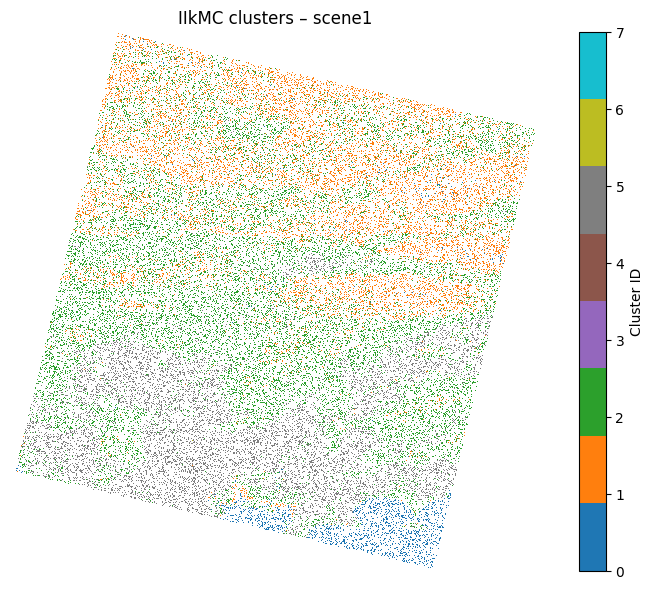

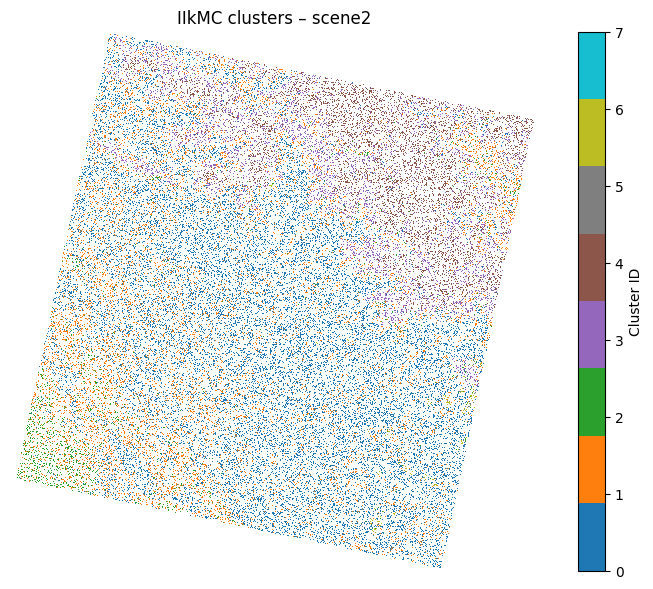

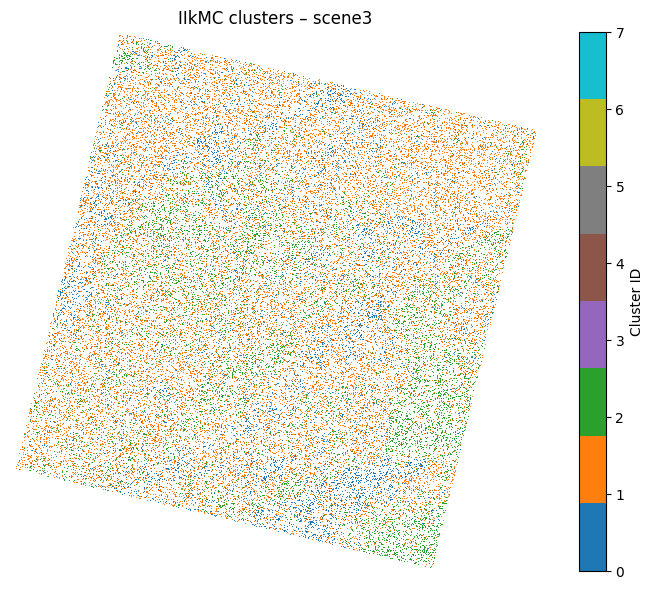

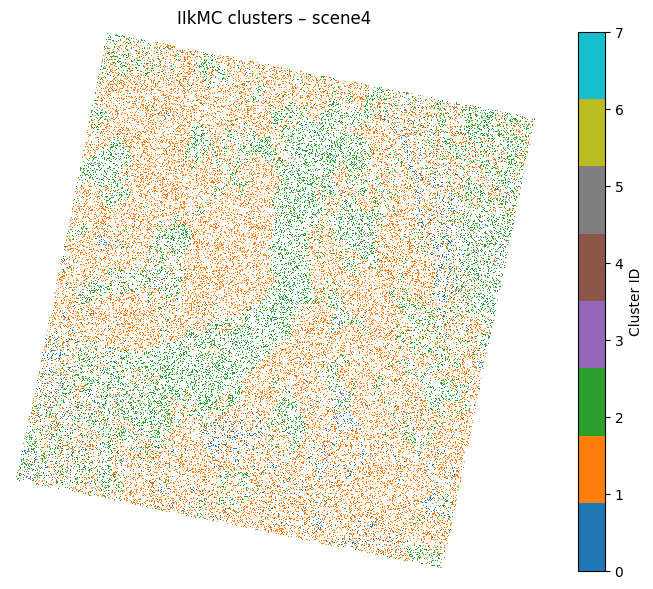

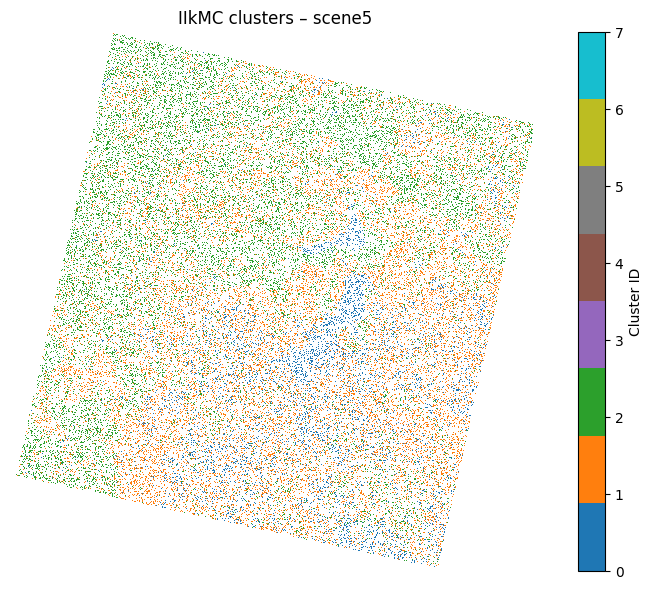

In [34]:
for sc_path, mask, scene_labels in zip(scene_paths, downsample_masks, labels):
    try:
        lbl2d = map_labels_back_downsampled(sc_path, mask, scene_labels)
        visualize_cluster_map(lbl2d, title=f"IIkMC clusters – {sc_path.name}", k=centres.shape[0])
    except Exception as e:
        print(f"⚠️ Skipping {sc_path.name}: {e}")

In [35]:
import os

def visualize_cluster_map(label_map, title="", k=8, figsize=(10, 7), save_path=None):
    cmap = ListedColormap(plt.cm.get_cmap('tab10', k).colors[:k])
    masked = np.ma.masked_where(np.isnan(label_map), label_map)
    
    plt.figure(figsize=figsize)
    plt.imshow(masked, cmap=cmap, interpolation='nearest')
    plt.title(title)
    plt.axis('off')
    plt.colorbar(ticks=range(k), label='Cluster ID')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"✅ Saved: {save_path}")
    
    plt.close()  # Don't display the plot in notebook (saves RAM)


In [40]:
output_dir = "/kaggle/working/clustermaps"
os.makedirs(output_dir, exist_ok=True)

for sc_path, mask, scene_labels in zip(scene_paths, downsample_masks, labels):
    try:
        lbl2d = map_labels_back_downsampled(sc_path, mask, scene_labels)
        save_file = os.path.join(output_dir, f"{sc_path.name}_clusters.png")
        visualize_cluster_map(lbl2d, title=f"IIkMC clusters – {sc_path.name}", k=centres.shape[0], save_path=save_file)
    except Exception as e:
        print(f"⚠️ Skipping {sc_path.name}: {e}")


/tmp/ipykernel_1248/3338081279.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = ListedColormap(plt.cm.get_cmap('tab10', k).colors[:k])


✅ Saved: /kaggle/working/clustermaps/scene1_clusters.png
✅ Saved: /kaggle/working/clustermaps/scene2_clusters.png
✅ Saved: /kaggle/working/clustermaps/scene3_clusters.png
✅ Saved: /kaggle/working/clustermaps/scene4_clusters.png
✅ Saved: /kaggle/working/clustermaps/scene5_clusters.png


In [38]:
os.cpu_count()

4

In [39]:
import time

# Assume `flat_scenes_ds` is your downsampled list of scenes
results = {}

for n in [1, 2, 4]:
    print(f"\n--- Running with {n} worker(s) ---")
    start = time.time()
    centers, labels = iikmc_cpu(flat_scenes_ds, k=8, n_workers=n, verbose=False)
    end = time.time()
    duration = end - start
    results[n] = duration
    print(f"Finished in {duration:.2f} seconds")



--- Running with 1 worker(s) ---


IIkMC:   0%|          | 0/100 [00:00<?, ?iter/s]

IIkMC:   1%|          | 1/100 [00:23<38:26, 23.30s/iter]

IIkMC:   2%|▏         | 2/100 [00:44<36:28, 22.33s/iter]

IIkMC:   3%|▎         | 3/100 [01:06<35:11, 21.77s/iter]

IIkMC:   4%|▍         | 4/100 [01:27<34:41, 21.68s/iter]

IIkMC:   5%|▌         | 5/100 [01:49<34:21, 21.70s/iter]

IIkMC:   6%|▌         | 6/100 [02:10<33:43, 21.53s/iter]

IIkMC:   7%|▋         | 7/100 [02:31<33:09, 21.39s/iter]

IIkMC:   8%|▊         | 8/100 [02:52<32:39, 21.30s/iter]

IIkMC:   9%|▉         | 9/100 [03:14<32:18, 21.30s/iter]

IIkMC:  10%|█         | 10/100 [03:34<31:34, 21.05s/iter]

IIkMC:  11%|█         | 11/100 [03:55<31:03, 20.94s/iter]

IIkMC:  12%|█▏        | 12/100 [04:15<30:38, 20.89s/iter]

IIkMC:  13%|█▎        | 13/100 [04:36<30:17, 20.89s/iter]

IIkMC:  14%|█▍        | 14/100 [04:59<30:49, 21.51s/iter]

IIkMC:  15%|█▌        | 15/100 [05:23<31:18, 22.10s/iter]

IIkMC:  16%|█▌        | 16/100 [05:46<31:34, 22.56s/iter]

IIkMC:  17%|█▋        | 17/100 [06:10<31:35, 22.83s/iter]

IIkMC:  18%|█▊        | 18/100 [06:33<31:20, 22.93s/iter]

IIkMC:  19%|█▉        | 19/100 [06:56<31:04, 23.02s/iter]

IIkMC:  20%|██        | 20/100 [07:20<30:52, 23.15s/iter]

IIkMC:  21%|██        | 21/100 [07:43<30:33, 23.21s/iter]

IIkMC:  22%|██▏       | 22/100 [08:06<30:13, 23.25s/iter]

IIkMC:  22%|██▏       | 22/100 [08:30<30:09, 23.20s/iter]


Finished in 521.06 seconds

--- Running with 2 worker(s) ---


IIkMC:   0%|          | 0/100 [00:00<?, ?iter/s]

IIkMC:   1%|          | 1/100 [00:16<27:27, 16.64s/iter]

IIkMC:   2%|▏         | 2/100 [00:29<23:54, 14.64s/iter]

IIkMC:   3%|▎         | 3/100 [00:43<23:03, 14.27s/iter]

IIkMC:   4%|▍         | 4/100 [00:56<21:54, 13.69s/iter]

IIkMC:   5%|▌         | 5/100 [01:09<21:20, 13.48s/iter]

IIkMC:   6%|▌         | 6/100 [01:22<20:47, 13.27s/iter]

IIkMC:   7%|▋         | 7/100 [01:35<20:26, 13.19s/iter]

IIkMC:   8%|▊         | 8/100 [01:48<20:18, 13.24s/iter]

IIkMC:   9%|▉         | 9/100 [02:01<19:59, 13.18s/iter]

IIkMC:  10%|█         | 10/100 [02:20<22:05, 14.73s/iter]

IIkMC:  11%|█         | 11/100 [02:32<20:58, 14.14s/iter]

IIkMC:  12%|█▏        | 12/100 [02:45<20:15, 13.81s/iter]

IIkMC:  13%|█▎        | 13/100 [02:59<19:54, 13.73s/iter]

IIkMC:  14%|█▍        | 14/100 [03:12<19:16, 13.45s/iter]

IIkMC:  15%|█▌        | 15/100 [03:25<19:02, 13.44s/iter]

IIkMC:  16%|█▌        | 16/100 [03:38<18:41, 13.35s/iter]

IIkMC:  17%|█▋        | 17/100 [03:51<18:14, 13.18s/iter]

IIkMC:  18%|█▊        | 18/100 [04:04<17:51, 13.06s/iter]

IIkMC:  19%|█▉        | 19/100 [04:17<17:34, 13.01s/iter]

IIkMC:  20%|██        | 20/100 [04:30<17:26, 13.08s/iter]

IIkMC:  21%|██        | 21/100 [04:43<17:10, 13.05s/iter]

IIkMC:  22%|██▏       | 22/100 [04:56<16:53, 12.99s/iter]

IIkMC:  22%|██▏       | 22/100 [05:09<18:17, 14.07s/iter]


Finished in 319.00 seconds

--- Running with 4 worker(s) ---


IIkMC:   0%|          | 0/100 [00:00<?, ?iter/s]

IIkMC:   1%|          | 1/100 [00:14<23:30, 14.25s/iter]

IIkMC:   2%|▏         | 2/100 [00:26<21:23, 13.10s/iter]

IIkMC:   3%|▎         | 3/100 [00:38<20:31, 12.69s/iter]

IIkMC:   4%|▍         | 4/100 [00:51<20:13, 12.64s/iter]

IIkMC:   5%|▌         | 5/100 [01:07<22:14, 14.05s/iter]

IIkMC:   6%|▌         | 6/100 [01:20<21:30, 13.72s/iter]

IIkMC:   7%|▋         | 7/100 [01:33<20:39, 13.33s/iter]

IIkMC:   8%|▊         | 8/100 [01:45<19:52, 12.97s/iter]

IIkMC:   9%|▉         | 9/100 [01:58<19:27, 12.83s/iter]

IIkMC:  10%|█         | 10/100 [02:10<18:56, 12.62s/iter]

IIkMC:  11%|█         | 11/100 [02:22<18:39, 12.58s/iter]

IIkMC:  12%|█▏        | 12/100 [02:35<18:17, 12.47s/iter]

IIkMC:  13%|█▎        | 13/100 [02:47<17:56, 12.38s/iter]

IIkMC:  14%|█▍        | 14/100 [03:00<17:57, 12.52s/iter]

IIkMC:  15%|█▌        | 15/100 [03:12<17:43, 12.51s/iter]

IIkMC:  16%|█▌        | 16/100 [03:24<17:24, 12.44s/iter]

IIkMC:  17%|█▋        | 17/100 [03:37<17:05, 12.36s/iter]

IIkMC:  18%|█▊        | 18/100 [03:49<16:57, 12.41s/iter]

IIkMC:  19%|█▉        | 19/100 [04:02<16:55, 12.54s/iter]

IIkMC:  20%|██        | 20/100 [04:14<16:35, 12.45s/iter]

IIkMC:  21%|██        | 21/100 [04:26<16:20, 12.41s/iter]

IIkMC:  22%|██▏       | 22/100 [04:39<16:12, 12.47s/iter]

IIkMC:  22%|██▏       | 22/100 [04:51<17:14, 13.26s/iter]

Finished in 300.91 seconds
